## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [12]:
# If you didn't download it yet, please get the relevant file now!
!wget "https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt" -P "./05data/"

--2020-11-10 15:23:39--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2020-11-10 15:23:40--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfdd226d66efde2398815e7430a.dl.dropboxusercontent.com/cd/0/inline/BC43DJ1kmarGJKr8G_joqhGtTl8mTv71xSkHmCy0KeHfATExezqUWvtQ9fEwUtiYYF-1AyYoTc8vH6iXinkWMK4ckO05ttcRpZUDCuppap9-ClvYGQ5vmr_aoTTVXNKvZXA/file# [following]
--2020-11-10 15:23:40--  https://ucfdd226d66efde2398815e7430a.dl.dropboxusercontent.com/cd/0/inline/BC43DJ1kmarGJKr8G_joqhGtTl8mTv71xSkHmCy0KeHfATExezqUWvtQ9fEwUtiYYF-1AyYoTc8vH6iXinkWMK4ckO05ttcRpZUDCu

### 1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [23]:
import numpy as np
import pandas as pd

In [26]:
N = 20000
data = pd.read_csv("./05data/data_000637.txt",nrows=N)
#data["ORBIT_CNT"][:50].plot()

In [27]:
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


### 2\. Find out the number of BX in a ORBIT (the value 'x').

If I correctly understood that the BX_COUNTER  is resetted after the increase of ORBIT_CNT, then the BX count associated to a given orbit can be obtained as follows:

In [28]:
BX_of_ORBIT = data.groupby("ORBIT_CNT").max()["BX_COUNTER"]
print(BX_of_ORBIT)

ORBIT_CNT
3869200167    3187
3869200168    3538
3869200169    2766
3869200170    3377
3869200171    3542
              ... 
3869200362    3425
3869200363    3460
3869200364    3352
3869200365    2787
3869200366    2522
Name: BX_COUNTER, Length: 200, dtype: int64


### 3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

I assume now that, to each BX_counter unit, are associated a maximum of $30$ TDC_MEAS, corresponding in total to $25ns$.

The total time spanned in the extracted dataset is then coputed as the product of $25ns$ for the maximum value reached by the BX counter in a given orbit, summing over the contribution of each orbit.

In [30]:
time_span = (BX_of_ORBIT*30).sum()
print("time_span = {} ms".format(time_span/1e6))

time_span = 19.45461 ms


For the total dataset, time span is around one second.

In [70]:
print("measuring time for the first {} data: ".format(N), BX_of_ORBIT.sum()*25/10e9, "s")

measuring time for the first 20000 data:  0.0016212175 s


### 4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [86]:
BX_ns=data["TDC_MEAS"]*data["BX_COUNTER"] # bx counter time in ns

# composing shifts of orbit col on gets  a col which is 1 only on the last row of an orbit, and 0 else
# this col is multiplied with BX_ns col (registering the max time within each)
# this cos is shifted by 1 and cumsummed, obtaining the step function registering the ofsets of each orbit
# the relative time within rech orbit is finally added
data["ABS_TIME"] = ((data["ORBIT_CNT"].shift(-1,fill_value=0)-data["ORBIT_CNT"]) * BX_ns).shift(1,fill_value=0).cumsum()+BX_ns
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,61724
1,1,0,124,3869200167,2374,27,64098
2,1,0,63,3869200167,2553,28,71484
3,1,0,64,3869200167,2558,19,48602
4,1,0,64,3869200167,2760,25,69000
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,9306218
19996,1,0,63,3869200366,2517,6,9248443
19997,1,0,32,3869200366,2519,5,9245936
19998,1,0,17,3869200366,2522,21,9286303


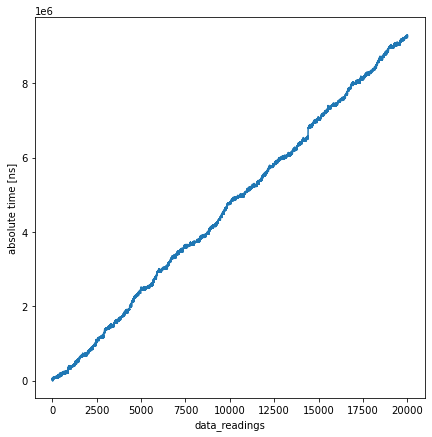

In [99]:
data["ABS_TIME"].plot(figsize=[7,7],xlabel="data_readings",ylabel="absolute time [ns]");

### 5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [121]:
data["HEAD"] = np.random.randint(low=0,high=2,size=len(data))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,61724
1,1,0,124,3869200167,2374,27,64098
2,1,0,63,3869200167,2553,28,71484
3,0,0,64,3869200167,2558,19,48602
4,0,0,64,3869200167,2760,25,69000
...,...,...,...,...,...,...,...
19995,0,0,27,3869200366,2513,29,9306218
19996,1,0,63,3869200366,2517,6,9248443
19997,0,0,32,3869200366,2519,5,9245936
19998,0,0,17,3869200366,2522,21,9286303
